In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt 

In [2]:
courses = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_courses.csv')
logs = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_logs.csv')
regs = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_registrations.csv')
sections = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_sections.csv')
tasks = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_tasks.csv')
users = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_users.csv')

In [3]:
users.head()

,createdAt,special_flagged,uuid
0,2011-08-03,0,97665
1,2011-08-11,0,68492
2,2011-08-03,0,52463
3,2011-08-19,0,129570
4,2011-08-04,0,45524


In [4]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [5]:
logs.head()

,user_uuid,moment,kind,iterable_uuid
0,57928,2016-09-12,EXERCISE_ANSWERED,2918d775-73e8-4c33-a3b7-5f0726bbe3ca
1,73719,2016-09-12,EXERCISE_ANSWERED,1315cdde-14e1-412d-bc3b-5da04b7aa44a
2,38957,2016-09-12,EXERCISE_ANSWERED,2ec53649-0eae-4114-b21f-ad72d448180b
3,59788,2016-09-12,EXERCISE_ANSWERED,ad5ae7b6-918f-4dfe-8680-db2928fe732c
4,73719,2016-09-12,EXERCISE_ANSWERED,7e08ee37-3eb6-4412-a6dd-d01f5619d2a2


In [6]:
sections.head()

,number,active,uuid,course_uuid
0,1,1,3988,588
1,2,1,6725,588
2,3,1,3716,588
3,4,1,4125,588
4,5,1,5354,588


In [7]:
regs.head()

,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,36802,113,2015-09-15 06:33:25,2015-09-28 21:54:56,2017-11-28 16:22:04,IN_PROGRESS
1,34892,764,2015-09-15 00:00:21,2016-03-01 14:11:05,2016-10-18 13:15:22,IN_PROGRESS
2,37440,764,2015-09-15 00:00:21,NaN,2015-09-15 00:00:21,IN_PROGRESS
3,58529,76,2015-09-15 00:00:20,NaN,2018-03-14 20:27:27,NOT_VISIBLE
4,48059,76,2015-09-15 00:00:20,NaN,2015-09-15 00:00:20,IN_PROGRESS


In [8]:
tasks.head()

,kind,duration,status,createdAt,uuid,course_uuid
0,VIDEO,31,ACTIVE,2015-10-21,21316,588
1,VIDEO,188,ACTIVE,2015-10-21,13646,588
2,HQ_EXPLANATION,0,ACTIVE,2015-10-21,45401,588
3,OPEN_QUESTION,0,ACTIVE,2015-10-21,37691,588
4,OPEN_QUESTION,0,ACTIVE,2015-10-21,9310,588


In [9]:
tasks['kind'].value_counts()

VIDEO              16366
SINGLE_CHOICE       9138
HQ_EXPLANATION      8853
TEXT_CONTENT        6599
OPEN_QUESTION       3075
MULTIPLE_CHOICE     1439
EXTRA_CONTENT          1
Name: kind, dtype: int64

In [10]:
logs['kind'].value_counts()

EXERCISE_ANSWERED      18000612
COURSE_FINISHED          426290
FORUM_POSTED              67213
FORUM_SOLVED              13963
CAREER_FINISHED           12514
DEGREE_FINISHED            9247
SUGGESTION_APPROVED        3558
PROJECT_APPROVED             74
Name: kind, dtype: int64

Análise dos alunos que interagem com a plataforma (através dos foruns):

In [11]:
logsForum = logs.copy()
logsForum.drop(['iterable_uuid'],axis=1,inplace=True)

logsForum = logsForum[logsForum.kind!='COURSE_FINISHED']
logsForum = logsForum[logsForum.kind!='CAREER_FINISHED']
logsForum = logsForum[logsForum.kind!='DEGREE_FINISHED']
logsForum = logsForum[logsForum.kind!='PROJECT_APPROVED']
logsForum = logsForum[logsForum.kind!='EXERCISE_ANSWERED']

logsForum['somaForum'] = logsForum.groupby(['user_uuid','moment'])['kind'].transform('count')
logsForum.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsForum.drop(['kind'],axis=1,inplace=True)

logsForum.head()

,user_uuid,moment,somaForum
526,13258,2016-09-12,4
1010,119614,2016-09-12,2
1029,86326,2016-09-12,2
1755,85621,2016-09-12,1
1873,82046,2016-09-12,1


In [12]:
logsForum.shape

(45865, 3)

In [13]:
logsEx = logs[logs['user_uuid'].isin(logsForum['user_uuid'])]

logsEx = logsEx[logsEx.kind!='FORUM_SOLVED']
logsEx = logsEx[logsEx.kind!='FORUM_POSTED']
logsEx = logsEx[logsEx.kind!='SUGGESTION_APPROVED']

logsEx.drop(['iterable_uuid'],axis=1,inplace=True)
logsEx['somaEx'] = logsEx.groupby(['user_uuid','moment'])['kind'].transform('count')
logsEx.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsEx.drop(['kind'],axis=1,inplace=True)
logsEx.head()

,user_uuid,moment,somaEx
0,57928,2016-09-12,47
2,38957,2016-09-12,2
16,117109,2016-09-12,3
20,88787,2016-09-12,3
21,16502,2016-09-12,11


In [14]:
logsEx.shape

(741149, 3)

In [15]:
forumEx = logsForum.merge(logsEx, left_on=['user_uuid','moment'], right_on=['user_uuid','moment'])
forumEx = forumEx[(forumEx['somaEx'] < 300)]
forumEx.head

<bound method NDFrame.head of        user_uuid      moment  somaForum  somaEx
0          13258  2016-09-12          4       1
1         119614  2016-09-12          2       4
2          82046  2016-09-12          1      42
3          86063  2016-09-12          1      11
4         102848  2016-09-12          1       3
...          ...         ...        ...     ...
24061      31289  2020-08-26          1       5
24062     113926  2020-08-26          1       1
24063      93331  2020-08-26          1       9
24064      87607  2020-08-26          1       7
24065      95571  2020-08-26          2       7

[24059 rows x 4 columns]>

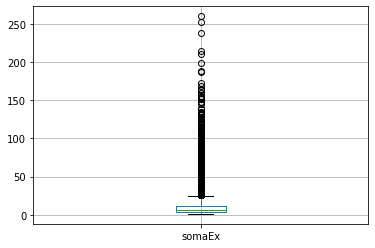

In [16]:
forumEx.boxplot(column='somaEx', return_type='axes')

In [17]:
forumEx['somaEx'].describe()

count    24059.000000
mean         9.953074
std         12.904675
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        260.000000
Name: somaEx, dtype: float64

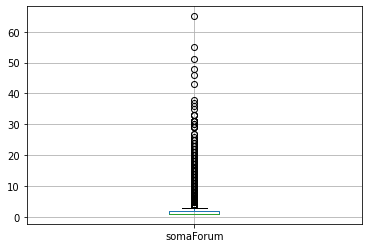

In [18]:
forumEx.boxplot(column='somaForum', return_type='axes')

In [19]:
forumEx['somaForum'].describe()

count    24059.000000
mean         1.787190
std          2.193431
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         65.000000
Name: somaForum, dtype: float64

In [20]:
forumEx.shape

(24059, 4)

In [21]:
users.shape

(132935, 3)

In [22]:
activeYears = users[users['uuid'].isin(forumEx['user_uuid'])]
createdDates= [pd.to_datetime(d) for d in activeYears['createdAt']]
activeYears['yearsActive'] = [relativedelta(datetime.now(), d).years for d in createdDates]
activeYears['creationDate'] = [i for i in createdDates]
activeYears.drop(['createdAt','special_flagged'],axis=1,inplace=True)
activeYears

<ipython-input-22-4060631c237e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeYears['yearsActive'] = [relativedelta(datetime.now(), d).years for d in createdDates]
<ipython-input-22-4060631c237e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeYears['creationDate'] = [i for i in createdDates]
C:\Users\gabriel\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,uuid,yearsActive,creationDate
3,129570,9,2011-08-19
64,55367,9,2011-09-22
69,41377,9,2011-09-22
77,124499,9,2011-09-23
123,41067,9,2011-10-10
...,...,...,...
132560,93331,0,2020-08-20
132578,73528,0,2020-08-21
132666,56776,0,2020-08-22
132749,132609,0,2020-08-24


In [23]:
forumEx.corr()

,user_uuid,somaForum,somaEx
user_uuid,1.000000,-0.021583,0.024264
somaForum,-0.021583,1.000000,0.031453
somaEx,0.024264,0.031453,1.000000


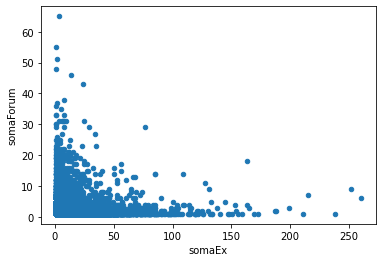

In [24]:
forumEx.plot(kind='scatter',x='somaEx',y='somaForum')
plt.show()

Com o plot de Forum X Exercícios acima, podemos perceber que não há uma correlação entre a atividade dos alunos nos fóruns e exercícios. Ademais, uma característica importante se tornou visível: conforme um aluno aumenta seu volume de atividades na plataforma, a tendência é que este se especialize em exercícios OU perguntas no fórum, nunca os dois juntos.

Relação entre tempo gasto em vídeo e quantidade de exercícios

In [25]:
tasksForumEx = forumEx.merge(tasks,left_on=['user_uuid'],right_on=['uuid'])
tasksForumEx.drop(['user_uuid','kind','status','createdAt'],axis=1,inplace=True)
tasksForumEx.drop_duplicates(subset=['uuid','moment'],inplace=True)

In [26]:
tasksForumEx

,moment,somaForum,somaEx,duration,uuid,course_uuid
0,2016-09-12,4,1,0,13258,723
1,2016-09-13,5,5,0,13258,723
2,2016-09-14,3,10,0,13258,723
3,2016-09-16,3,6,0,13258,723
4,2016-09-17,2,6,0,13258,723
...,...,...,...,...,...,...
8584,2020-08-24,1,4,0,28646,559
8585,2020-08-25,6,11,0,61619,613
8586,2020-08-26,1,4,0,61619,613
8587,2020-08-25,1,1,0,62549,394


Corroborando com o que foi dito anteriormente, aqui vemos, mais uma vez, a ausência de relação entre 

In [27]:
tasksForumEx.corr()

,somaForum,somaEx,duration,uuid,course_uuid
somaForum,1.000000,-0.005373,-0.062605,0.044326,-0.015683
somaEx,-0.005373,1.000000,-0.006926,0.028276,0.020815
duration,-0.062605,-0.006926,1.000000,0.000890,-0.049521
uuid,0.044326,0.028276,0.000890,1.000000,0.010540
course_uuid,-0.015683,0.020815,-0.049521,0.010540,1.000000


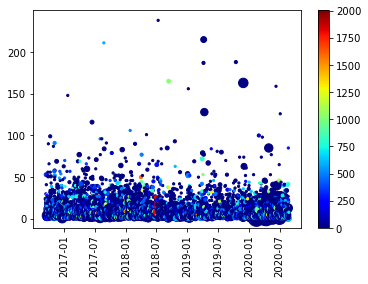

In [66]:
dates= [pd.to_datetime(d) for d in tasksForumEx['moment']]
du= [d for d in tasksForumEx['duration']]
plt.scatter(x=dates,y=tasksForumEx['somaEx'],s=tasksForumEx['somaForum']*5,c=du,cmap='jet')
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

Neste plot, percebemos algo interessante: o tempo que o aluno gasta em vídeo, representado no gráfico pela cor dos pontos, não tem correlação nem com a quantidade de exercícios feitos pelo aluno, nem com a atividade nos fóruns do mesmo. Ou seja, um aluno que assiste muitas aulas na plataforma não irá, necessáriamente, fazer muitos exercícios ou ser muito ativo nos fóruns online.

In [29]:
scores = tasksForumEx.copy()
scores['somaForum'] = scores.groupby('uuid')['somaForum'].transform('sum')
scores['somaEx'] = scores.groupby('uuid')['somaEx'].transform('sum')
scores.drop_duplicates(subset='uuid',inplace=True)
datedScores = scores.merge(activeYears[['uuid','yearsActive']],left_on='uuid',right_on='uuid')
temp = datedScores[['uuid']].merge(regs[['user_uuid','course_uuid']],left_on='uuid',right_on='user_uuid')
datedScores['courses'] = temp.groupby('uuid')['course_uuid'].transform('count')
datedScores.drop(['course_uuid','moment'],axis=1,inplace=True)

In [30]:
datedScores

,somaForum,somaEx,duration,uuid,yearsActive,courses
0,266,457,0,13258,4,28
1,2,10,981,53284,6,28
2,2,24,0,7455,4,28
3,1,7,0,39989,4,28
4,10,52,151,27744,4,28
...,...,...,...,...,...,...
2959,2,4,0,53331,0,12
2960,1,4,0,28646,0,12
2961,7,15,0,61619,0,12
2962,1,1,0,62549,3,12


Aqui, desenvolvemos uma metrica de score para os alunos

In [31]:
datedScores = datedScores[datedScores['courses']>0]
datedScores = datedScores[(datedScores['duration']<1200) & (datedScores['duration']>0)]
normalEx = datedScores['somaEx']/datedScores['somaEx'].mean()
normalForum = datedScores['somaForum']/datedScores['somaForum'].mean()
normalDuration = datedScores['duration']/datedScores['duration'].mean()
normalCourses = datedScores['courses']/datedScores['courses'].mean()

datedScores['score'] = (normalEx+normalForum+normalDuration)/normalCourses

In [32]:
datedScores

,somaForum,somaEx,duration,uuid,yearsActive,courses,score
1,2,10,981,53284,6,28,5.514413
4,10,52,151,27744,4,28,8.865532
5,2,26,85,16791,4,28,3.137688
6,2,44,192,57928,4,28,4.885787
10,14,86,601,25141,4,28,14.927590
...,...,...,...,...,...,...,...
2950,1,21,560,29650,0,8,14.733259
2952,1,4,496,38065,0,8,9.469169
2956,2,108,282,58784,4,8,34.822874
2957,1,4,1184,47885,0,8,19.018918


Após estabelecida a métrica, veremos dados a respeito de cada um dos quartis de pontuação

In [33]:
logFreq = logs[['user_uuid','moment']]
logFreq['entries'] = logFreq.groupby(['user_uuid','moment'])['moment'].transform('count')
logFreq.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logFreq['var'] = logFreq.groupby(['user_uuid'])['entries'].transform('var')
logFreq['std'] = logFreq.groupby(['user_uuid'])['entries'].transform('std')
logFreq

<ipython-input-33-9a428a2349a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logFreq['entries'] = logFreq.groupby(['user_uuid','moment'])['moment'].transform('count')
<ipython-input-33-9a428a2349a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logFreq.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
<ipython-input-33-9a428a2349a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,user_uuid,moment,entries,var,std
0,57928,2016-09-12,47,976.858974,31.254743
1,73719,2016-09-12,5,55.314407,7.437366
2,38957,2016-09-12,2,30.077558,5.484301
3,59788,2016-09-12,28,90.730488,9.525255
5,61315,2016-09-12,12,10.500000,3.240370
...,...,...,...,...,...
18533448,53472,2020-08-27,4,33.072727,5.750889
18533454,93015,2020-08-27,2,94.666667,9.729680
18533456,97279,2020-08-27,1,52.000000,7.211103
18533465,83062,2020-08-27,1,24.119540,4.911165


In [34]:
scoreFreq = datedScores.merge(logFreq[['user_uuid','var','entries','std']],left_on='uuid',right_on='user_uuid')
scoreFreq['entries'] = scoreFreq.groupby(['user_uuid'])['entries'].transform('sum')
scoreFreq.drop_duplicates(subset='user_uuid',inplace=True)

In [123]:
scoreFreq['logScore'] = np.log(scoreFreq['score'])
scoreFreq['logCourses'] = np.log(scoreFreq['courses'])
scoreFreq['negVar'] = 1/scoreFreq['var']

In [36]:
scoreFreq['logCourses'].corr(scoreFreq['logScore'])

-0.7546929547849937

In [37]:
scoreFreq.shape

(1007, 13)

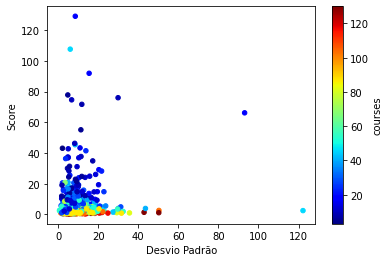

In [130]:
fig, ax = plt.subplots()
scoreFreq.plot(kind='scatter',x='std',y='score',c='courses',colormap='jet',ax=ax)
plt.xlabel('Desvio Padrão')
plt.ylabel('Score')
plt.show()

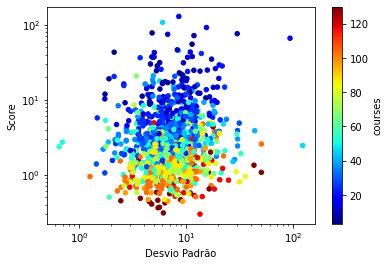

In [133]:
fig, ax = plt.subplots()
scoreFreq.plot(kind='scatter',x='std',y='score',colormap='jet',c='courses',loglog=True,ax=ax)
plt.xlabel('Desvio Padrão')
plt.ylabel('Score')
plt.show()

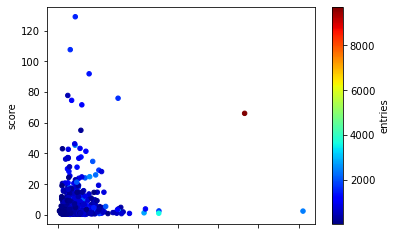

In [40]:
scoreFreq.plot(kind='scatter',x='std',y='score',colormap='jet',c='entries')
plt.show()

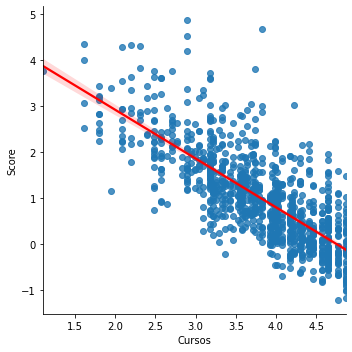

In [135]:
cmap = sns.cubehelix_palette(as_cmap=True)
sns.lmplot(x='logCourses',y='logScore',data=scoreFreq,palette=cmap,fit_reg=True,line_kws={'color': 'red'})
plt.xlabel('Cursos')
plt.ylabel('Score')
plt.show()

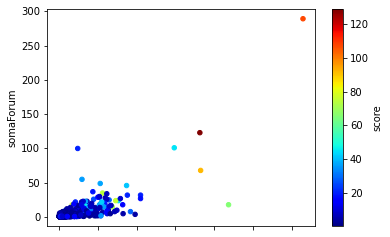

In [137]:
scoreFreq.plot(kind='scatter',x='somaEx',y='somaForum',colormap='jet',c='score')
plt.show()

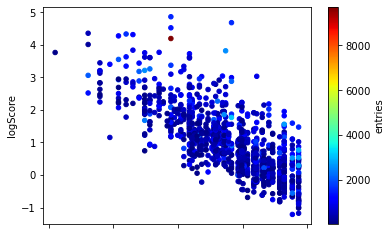

In [42]:
scoreFreq.plot(kind='scatter',x='logCourses',y='logScore',colormap='jet',c='entries')
plt.show()

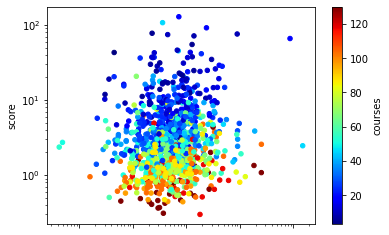

In [65]:
scoreFreq.plot(kind='scatter',x='var',y='score',colormap='jet',c='courses',loglog=True)
plt.show()

In [44]:
timeWatched = tasks[['duration','uuid']]
#remover 0 minutos (ruido)
timeWatched = timeWatched[(timeWatched['duration'] > 0) & (timeWatched['duration'] < 1500)]
timeWatched.sort_values(by='duration', ascending=False).head()

,duration,uuid
22063,1497,4298
35342,1496,49765
24124,1496,47443
39779,1490,12482
2646,1489,61167


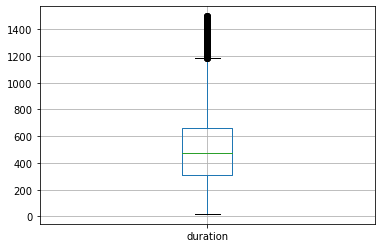

In [45]:
timeWatched.boxplot(column='duration', return_type='axes')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011490291F10>]],
      dtype=object)

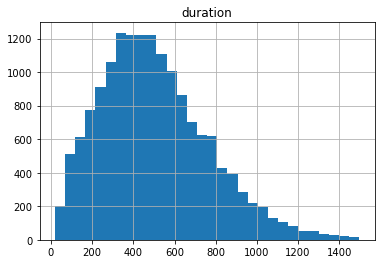

In [46]:
timeWatched.hist(column='duration',bins=30)

In [47]:
#pegar os top 25% com mais tempo assistido
top25 = timeWatched.sort_values(by='duration', ascending=False).head(int(len(timeWatched)*0.25))
top25.head()

,duration,uuid
22063,1497,4298
35342,1496,49765
24124,1496,47443
39779,1490,12482
2646,1489,61167


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001148F001B20>]],
      dtype=object)

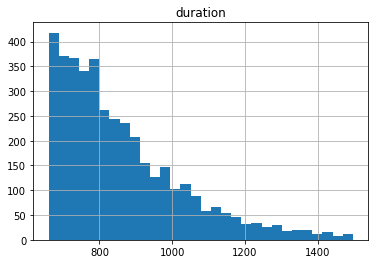

In [48]:
top25.hist(column='duration', bins=30)

Acima, temos a distribuição do tempo em que os alunos do quartil superior gastam na plataforma (Tempo em minutos X quantidade de alunos)

In [49]:
statuses = top25.merge(regs, left_on='uuid',right_on='user_uuid')
statuses.head()

,duration,uuid,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,1496,47443,47443,1012,2017-02-23 16:16:27,NaN,2017-05-03 22:38:01,IN_PROGRESS
1,1496,47443,47443,1039,2017-02-23 16:55:09,2017-03-12 22:31:50,2017-03-12 22:31:42,IN_PROGRESS
2,1496,47443,47443,1057,2017-02-23 22:00:18,2017-10-10 21:43:44,2017-10-10 21:44:39,IN_PROGRESS
3,1496,47443,47443,983,2017-02-23 22:00:55,2017-10-16 20:17:24,2018-01-08 20:26:25,IN_PROGRESS
4,1496,47443,47443,1002,2017-02-23 22:02:39,2017-02-24 00:26:42,2017-02-24 00:26:35,IN_PROGRESS


In [50]:
statuses = statuses[statuses.currentState!='NOT_VISIBLE']
statuses = statuses[statuses.currentState!='BOOKMARKED']

Aqui, fazemos a remoção de estados de curso irrelevantes para nossa análise, deixando apenas IN_PROGRESS e PAUSED a serem analisados

In [51]:
#curso completado -> com data e in_progress // curso pausado -> resto
statuses['completion'] = np.where((statuses['currentState']=='IN_PROGRESS') & (statuses['finishedAt'].notna()), 'completed', 'paused')

In [52]:
statuses.drop(['duration'],axis=1,inplace=True)
statuses.head()

,uuid,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState,completion
0,47443,47443,1012,2017-02-23 16:16:27,NaN,2017-05-03 22:38:01,IN_PROGRESS,paused
1,47443,47443,1039,2017-02-23 16:55:09,2017-03-12 22:31:50,2017-03-12 22:31:42,IN_PROGRESS,completed
2,47443,47443,1057,2017-02-23 22:00:18,2017-10-10 21:43:44,2017-10-10 21:44:39,IN_PROGRESS,completed
3,47443,47443,983,2017-02-23 22:00:55,2017-10-16 20:17:24,2018-01-08 20:26:25,IN_PROGRESS,completed
4,47443,47443,1002,2017-02-23 22:02:39,2017-02-24 00:26:42,2017-02-24 00:26:35,IN_PROGRESS,completed


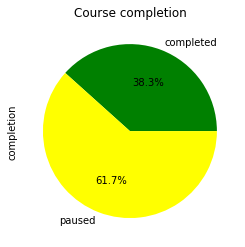

In [53]:
statuses.groupby('completion')['completion'].count().plot.pie(colors = ['green','yellow'], autopct='%1.1f%%',title='Course completion',)

In [54]:
statuses.groupby('completion')['completion'].count()

completion
completed     8405
paused       13512
Name: completion, dtype: int64

Pelo gráfico, percebe-se que a maioria dos alunos os quais consideramos "os mais estudiosos" não completam seus cursos, mas sim os pausam em pontos arbitrários, sem necessáriamente haver um critério

In [55]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [56]:
courses.groupby('level')['level'].count()

level
1     664
5     375
10     50
Name: level, dtype: int64

In [57]:
top25_courses = top25.merge(tasks, left_on='uuid',right_on='uuid')
top25_courses = top25_courses.merge(courses, left_on='course_uuid',right_on='uuid')
top25_courses.drop(['duration_x','duration_y','createdAt_x','createdAt_y','uuid_y'],axis=1,inplace=True)
top25_courses.head()

,uuid_x,kind,status,course_uuid,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,substitute_uuid
0,4298,VIDEO,ACTIVE,591,1,2018-04-06,0,107,PUBLISHED,0,NaN,NaN
1,18189,VIDEO,ACTIVE,591,1,2018-04-06,0,107,PUBLISHED,0,NaN,NaN
2,33089,VIDEO,ACTIVE,591,1,2018-04-06,0,107,PUBLISHED,0,NaN,NaN
3,26139,VIDEO,ACTIVE,591,1,2018-04-06,0,107,PUBLISHED,0,NaN,NaN
4,2363,VIDEO,ACTIVE,591,1,2018-04-06,0,107,PUBLISHED,0,NaN,NaN


In [58]:
top25_courses.groupby('level')['level'].count()

level
1     2350
5     1463
10     175
Name: level, dtype: int64

Temos abaixo o gráfico que ilustra uma predominância de cursos considerados "mais fáceis" dentre esse público.

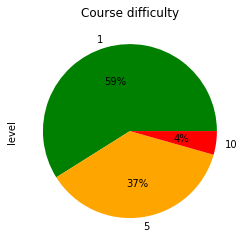

In [59]:
top25_courses.groupby('level')['level'].count().plot.pie(colors = ['green','orange','red'], autopct='%1.0f%%',title='Course difficulty')

In [60]:
teste = statuses.merge(top25_courses, left_on='uuid',right_on='uuid_x')
teste.drop(['uuid_x', 'course_uuid_y'],axis=1,inplace=True)
teste['completion'] = teste['completion'].replace('completed', 1)
teste['completion'] = teste['completion'].replace('paused', 0)
teste['courseCount'] = teste.groupby('uuid')['course_uuid_x'].transform('count')
teste['completionRate'] = 100*teste.groupby(by=['uuid'])['completion'].transform('sum')/teste['courseCount']
teste = teste[['uuid','completionRate','courseCount']]
teste.drop_duplicates(subset=['uuid'],keep='first',inplace=True)
teste.head()

,uuid,completionRate,courseCount
0,47443,64.864865,37
37,12482,66.666667,3
40,61167,60.000000,5
45,24052,0.000000,2
47,19775,38.709677,31


Finalmente, temos abaixo uma distribuição ta taxa de conclusão dos cursos entre os 25% mais ativos na plataforma.

Text(0.5, 1.0, 'Taxa de completude dos cursos')

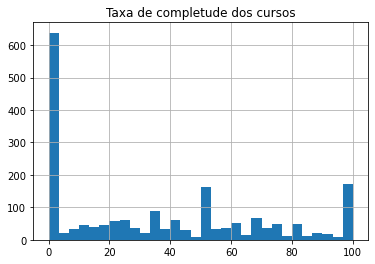

In [61]:
teste.hist(column='completionRate',bins=30)
plt.title('Taxa de completude dos cursos')

Percebemos aqui que, em par com o que já foi comentado anteriormente, a grande maioria dos alunos analisados não completa nem 20% dos cursos em que se inscreve.